In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import duckdb
connection = duckdb.connect()
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
import warnings
import joblib
warnings.filterwarnings("ignore")
from tqdm import tqdm
from gbcv import GbCV

# FIT

In [2]:
sql_command = '''
with df as (
    select * from read_parquet(['cleaned.parquet'])
    )

select 
    date_trunc('hour', TIMESTAMP) as hour,
    date_trunc('week', TIMESTAMP) as week,
    date_trunc('month', TIMESTAMP) as month,
    * from df where Visibility_Avg between 1000 and 19900
'''
df = connection.execute(sql_command).df()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228511 entries, 0 to 228510
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   hour            228511 non-null  datetime64[ns]
 1   week            228511 non-null  datetime64[ns]
 2   month           228511 non-null  datetime64[ns]
 3   TIMESTAMP       228511 non-null  datetime64[ns]
 4   region          228511 non-null  object        
 5   Temp_Avg        222943 non-null  float32       
 6   WSpeed_AVG      227552 non-null  float32       
 7   WSPeed_Max      29797 non-null   float32       
 8   WDir_SD         228386 non-null  float32       
 9   Rain_Tot        228511 non-null  float32       
 10  Press_Avg       227236 non-null  float32       
 11  Rad_Avg         101317 non-null  float32       
 12  Visibility_Avg  228511 non-null  float32       
 13  Visibility      0 non-null       float32       
 14  RH_Avg          224454 non-null  flo

In [5]:
sql_command = '''
with df as (
    select * from read_parquet(['cleaned.parquet'])
    )

select 
    date_trunc('hour', TIMESTAMP) as hour,
    date_trunc('week', TIMESTAMP) as week,
    date_trunc('month', TIMESTAMP) as month,
    * from df where Visibility_Avg is NULL
'''
dft = connection.execute(sql_command).df().sample(500000)
dft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 13433553 to 53010679
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   hour            500000 non-null  datetime64[ns]
 1   week            500000 non-null  datetime64[ns]
 2   month           500000 non-null  datetime64[ns]
 3   TIMESTAMP       500000 non-null  datetime64[ns]
 4   region          500000 non-null  object        
 5   Temp_Avg        413121 non-null  float32       
 6   WSpeed_AVG      416776 non-null  float32       
 7   WSPeed_Max      297555 non-null  float32       
 8   WDir_SD         423035 non-null  float32       
 9   Rain_Tot        432796 non-null  float32       
 10  Press_Avg       416750 non-null  float32       
 11  Rad_Avg         239859 non-null  float32       
 12  Visibility_Avg  0 non-null       float32       
 13  Visibility      83 non-null      float32       
 14  RH_Avg          413218 non-

In [7]:
dft['vis'] = 'NO'
df['vis'] = 'YES'
dft = pd.concat([df, dft])

In [20]:
# dft = dft.drop(columns={'Visibility'})
# dft = dft.drop(columns={'Visibility_Avg'})

In [19]:
dft.columns

Index(['hour', 'week', 'month', 'TIMESTAMP', 'region', 'Temp_Avg',
       'WSpeed_AVG', 'WSPeed_Max', 'WDir_SD', 'Rain_Tot', 'Press_Avg',
       'Rad_Avg', 'Visibility_Avg', 'RH_Avg', 'WDir_AVG', 'vis'],
      dtype='object')

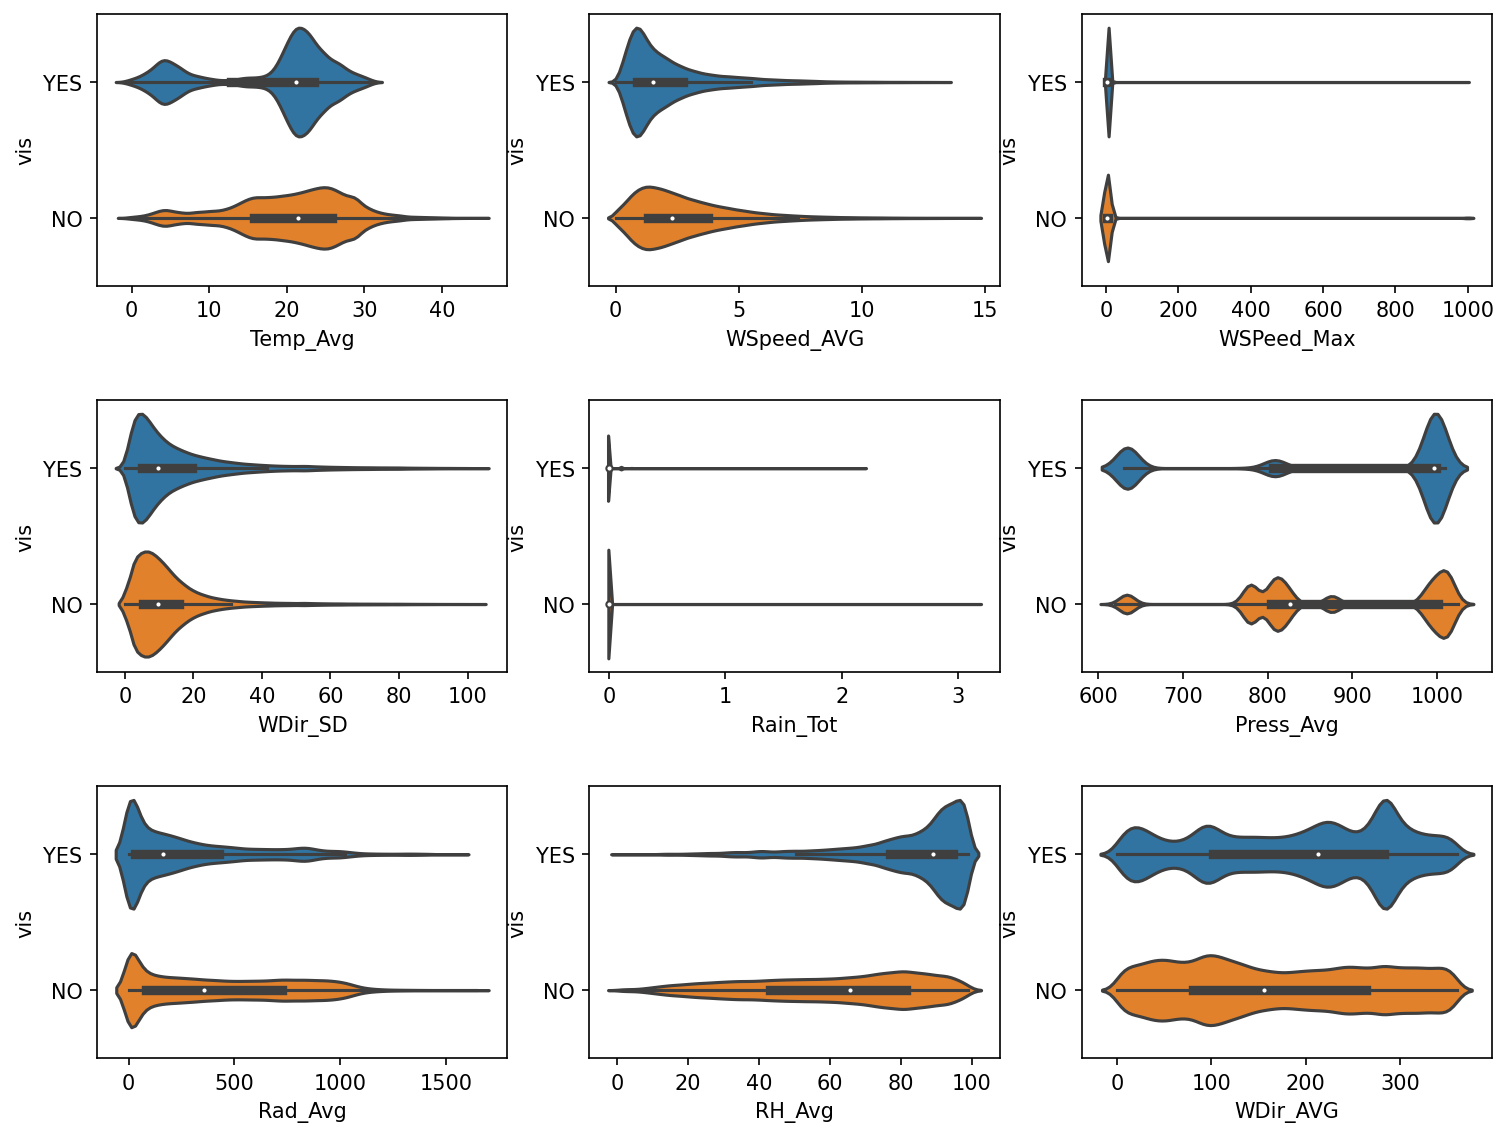

In [22]:
fig, axs = plt.subplots(3, 3, figsize=(12, 8), dpi=150)
n = 0
for i in range(3):
    for j in range(3):
        sns.violinplot(data=dft, y='vis', x=dft.columns[5 + n], ax=axs[i, j])
        box = axs[i, j].get_position()
        axs[i, j].set_position([box.x0, box.y0-0.05*i, box.width, box.height])
        n+=1

<AxesSubplot:ylabel='Frequency'>

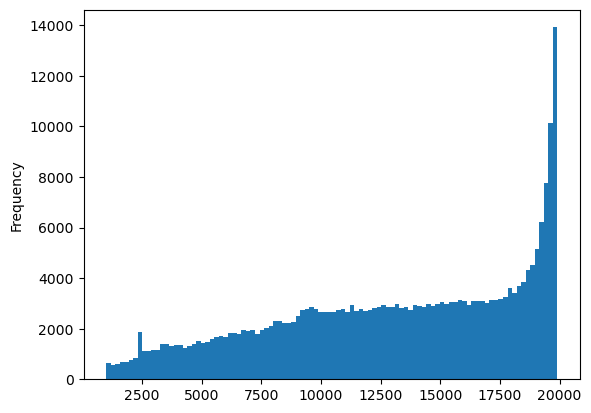

In [3]:
df.Visibility_Avg.plot.hist(bins=100)

<AxesSubplot:xlabel='month', ylabel='Visibility_Avg'>

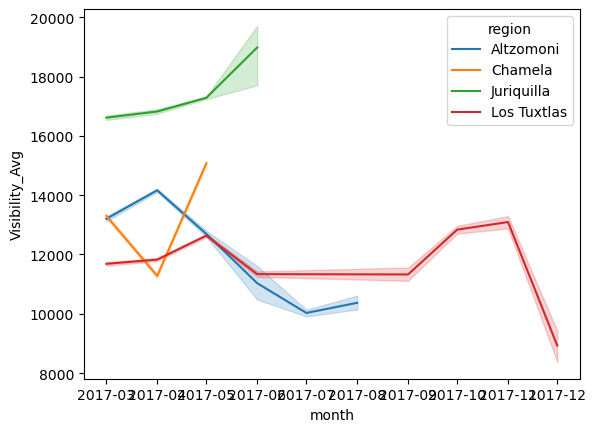

In [4]:
sns.lineplot(data=df, x='month', y='Visibility_Avg', hue='region')

In [5]:
X = df.sort_values(by=['region', 'TIMESTAMP']).drop(columns={'month', 'week', 'Visibility', 'WSpeed_Max', 'region'})
X['hour'] = X.hour.dt.hour
needed_col = ['TIMESTAMP', 'Temp_Avg', 'RH_Avg', 'WSpeed_Avg', 'WDir_Avg',
            'WDir_SD', 'Rain_Tot', 'Press_Avg', 'Rad_Avg']

dft = pd.concat([X, 
                 X[needed_col].shift(10).rename(columns = dict(zip( needed_col, map(lambda x: x+'_lag10', needed_col) ))), 
                 X[needed_col].shift(30).rename(columns = dict(zip( needed_col, map(lambda x: x+'_lag30', needed_col) ))), 
                 X[needed_col].shift(60).rename(columns = dict(zip( needed_col, map(lambda x: x+'_lag60', needed_col) ))),
                 X[needed_col].shift(90).rename(columns = dict(zip( needed_col, map(lambda x: x+'_lag90', needed_col) ))), 
                 X[needed_col].shift(120).rename(columns = dict(zip( needed_col, map(lambda x: x+'_lag120', needed_col) )))
                 ], axis=1)


X = dft[((dft.TIMESTAMP - dft.TIMESTAMP_lag10) < '1 days 00:00:00') & 
        ((dft.TIMESTAMP - dft.TIMESTAMP_lag30) < '1 days 00:00:00') &
        ((dft.TIMESTAMP - dft.TIMESTAMP_lag60) < '1 days 00:00:00') &
        ((dft.TIMESTAMP - dft.TIMESTAMP_lag90) < '1 days 00:00:00') &
        ((dft.TIMESTAMP - dft.TIMESTAMP_lag120) < '1 days 00:00:00')
        ]

X = X.drop(columns=X.filter(like='TIMESTAMP').columns)
y = X.Visibility_Avg
X = X.drop(columns='Visibility_Avg')
X.columns

Index(['hour', 'Temp_Avg', 'RH_Avg', 'WSpeed_Avg', 'WDir_Avg', 'WDir_SD',
       'Rain_Tot', 'Press_Avg', 'Rad_Avg', 'Temp_Avg_lag10', 'RH_Avg_lag10',
       'WSpeed_Avg_lag10', 'WDir_Avg_lag10', 'WDir_SD_lag10', 'Rain_Tot_lag10',
       'Press_Avg_lag10', 'Rad_Avg_lag10', 'Temp_Avg_lag30', 'RH_Avg_lag30',
       'WSpeed_Avg_lag30', 'WDir_Avg_lag30', 'WDir_SD_lag30', 'Rain_Tot_lag30',
       'Press_Avg_lag30', 'Rad_Avg_lag30', 'Temp_Avg_lag60', 'RH_Avg_lag60',
       'WSpeed_Avg_lag60', 'WDir_Avg_lag60', 'WDir_SD_lag60', 'Rain_Tot_lag60',
       'Press_Avg_lag60', 'Rad_Avg_lag60', 'Temp_Avg_lag90', 'RH_Avg_lag90',
       'WSpeed_Avg_lag90', 'WDir_Avg_lag90', 'WDir_SD_lag90', 'Rain_Tot_lag90',
       'Press_Avg_lag90', 'Rad_Avg_lag90', 'Temp_Avg_lag120', 'RH_Avg_lag120',
       'WSpeed_Avg_lag120', 'WDir_Avg_lag120', 'WDir_SD_lag120',
       'Rain_Tot_lag120', 'Press_Avg_lag120', 'Rad_Avg_lag120'],
      dtype='object')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.25, random_state=42)

In [7]:
searched_params = {'subsample': [0.4, 0.5, 0.6, 0.7],
                    'reg_lambda': [0, 1, 30, 50, 75, 100],
                    'reg_alpha': [0, 1, 10, 30, 50, 100],
                    'num_leaves': [1023, 2047],
                    'min_child_weight': [0.01, 0.1, 1, 10],
                    'min_child_samples': [50],
                    'max_depth': [16, 20],
                    'learning_rate': [0.1],
                    'colsample_bytree': [0.4, 0.5, 0.6]}

frozen_parameters = {'objective': 'regression',
                    'metric': 'rmse',
                    'num_boost_round': 8192,
                    'verbose': -1}

model = GbCV(num_search=20, frozen_parameters=frozen_parameters, searched_parameters=searched_params)

model.fit(X_train, y_train, n_models=5)
joblib.dump(model, 'visibility_minutes_lag100_V3.pkl')

100%|██████████| 20/20 [2:47:46<00:00, 503.34s/it]  


[1]	valid_0's rmse: 4924.84
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 4707.46
[3]	valid_0's rmse: 4530.49
[4]	valid_0's rmse: 4351.62
[5]	valid_0's rmse: 4194.58
[6]	valid_0's rmse: 4036.81
[7]	valid_0's rmse: 3899.18
[8]	valid_0's rmse: 3780.03
[9]	valid_0's rmse: 3667
[10]	valid_0's rmse: 3565.25
[11]	valid_0's rmse: 3480.94
[12]	valid_0's rmse: 3388.67
[13]	valid_0's rmse: 3314.99
[14]	valid_0's rmse: 3238.37
[15]	valid_0's rmse: 3179.37
[16]	valid_0's rmse: 3118.7
[17]	valid_0's rmse: 3059.51
[18]	valid_0's rmse: 3003.75
[19]	valid_0's rmse: 2960.89
[20]	valid_0's rmse: 2913.94
[21]	valid_0's rmse: 2872.19
[22]	valid_0's rmse: 2835.16
[23]	valid_0's rmse: 2793.73
[24]	valid_0's rmse: 2765.34
[25]	valid_0's rmse: 2726.57
[26]	valid_0's rmse: 2691.17
[27]	valid_0's rmse: 2660.36
[28]	valid_0's rmse: 2629.21
[29]	valid_0's rmse: 2601.42
[30]	valid_0's rmse: 2571.48
[31]	valid_0's rmse: 2548.07
[32]	valid_0's rmse: 2521.1
[33]	valid_0's rmse: 2494

['visibility_minutes_lag100_V3.pkl']

In [8]:
# model = joblib.load('visibility_minutes_lag100_V2.pkl')
print(np.mean(model.rmse))
y_pred = model.predict(X_test)
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred, squared=False)

1637.3428181838701


1563.8497142322205

<AxesSubplot:xlabel='importance', ylabel='names'>

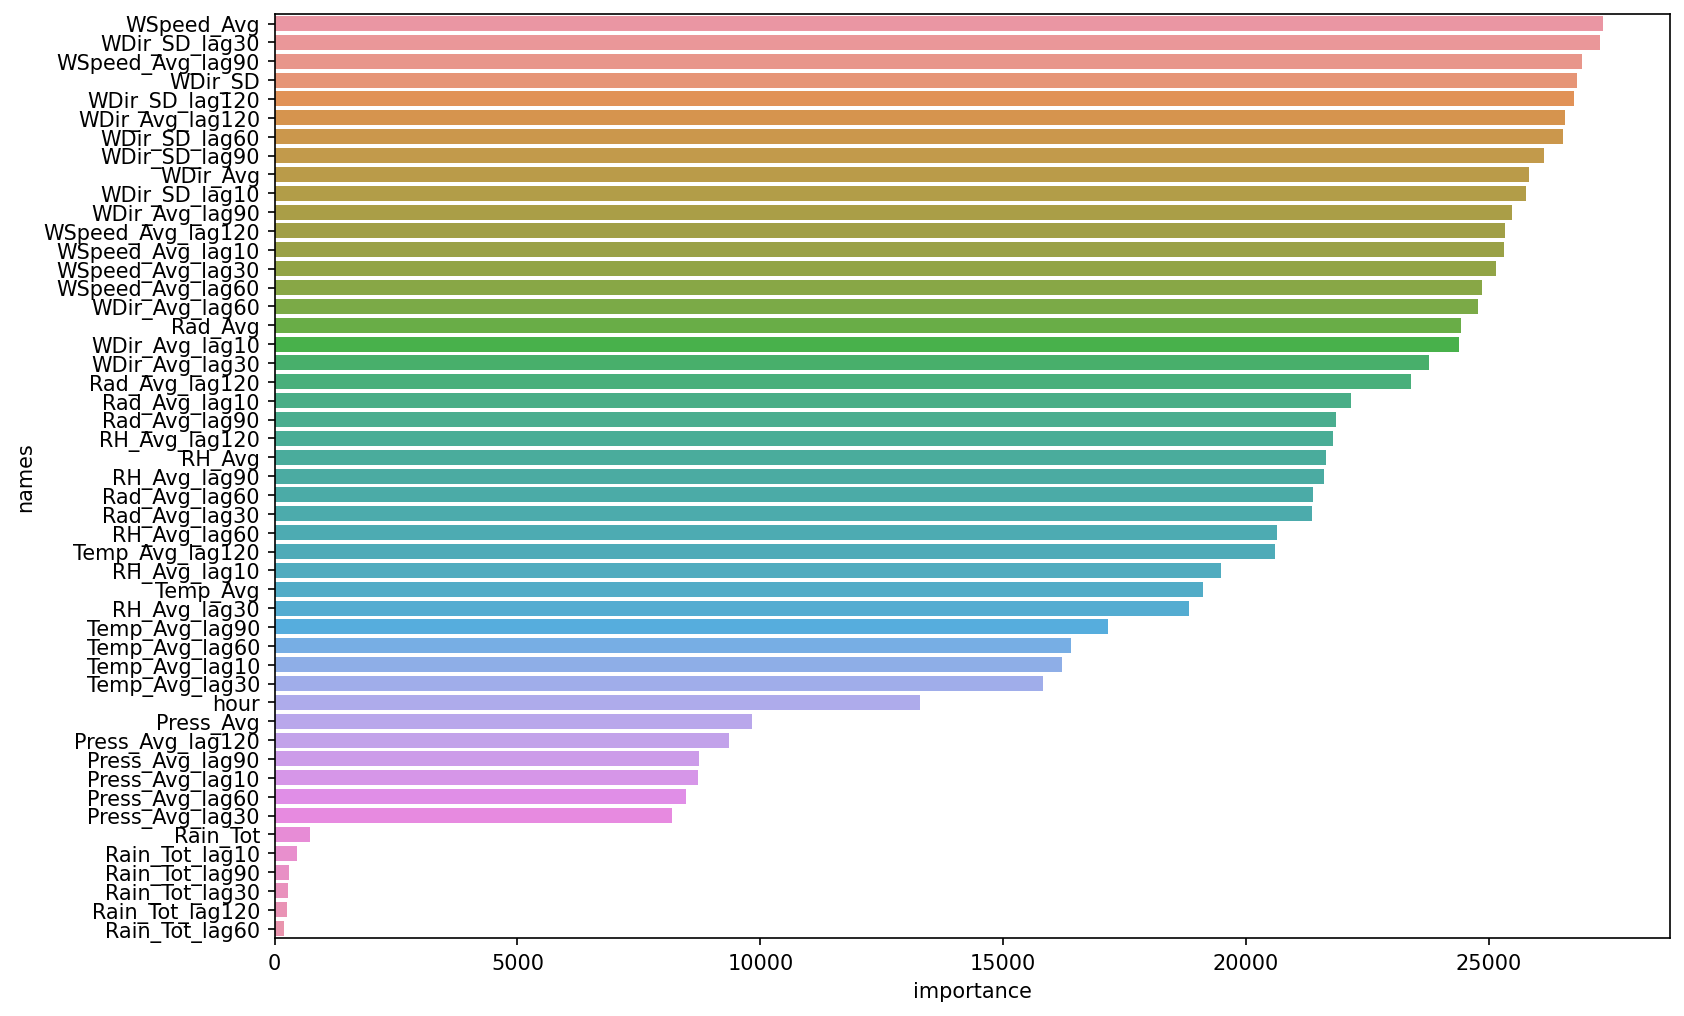

In [10]:
fig, ax = plt.subplots(figsize=(12, 8), dpi=150)
dft = pd.DataFrame({'names': X.columns, 'importance': np.mean([model.models[i].feature_importance() for i in range(5)], axis=0)}).sort_values(by='importance', ascending=False)
dft = dft[dft.names != 'random_column']
sns.barplot(data=dft, x='importance', y='names', ax=ax)

# Predict

In [6]:
def get_table(region):
    sql_command = f'''

    with df as (
        select * from read_parquet(['cleaned.parquet'])
        where region = '{region}'),

    lag10 as (
        select TIMESTAMP + interval '10 minutes' as TIMESTAMP_lag10,
        Temp_Avg             as Temp_Avg_lag10,
        RH_Avg               as RH_Avg_lag10,
        WSpeed_Avg           as WSpeed_Avg_lag10,
        WSpeed_Max           as WSpeed_Max_lag10,
        WDir_Avg             as WDir_Avg_lag10,
        WDir_SD              as WDir_SD_lag10,
        Rain_Tot             as Rain_Tot_lag10,
        Press_Avg            as Press_Avg_lag10,
        Rad_Avg              as Rad_Avg_lag10,
        region               as region_lag10
        from df
        ),

    lag30 as (
        select TIMESTAMP + interval '30 minutes' as TIMESTAMP_lag30,
        Temp_Avg             as Temp_Avg_lag30,
        RH_Avg               as RH_Avg_lag30,
        WSpeed_Avg           as WSpeed_Avg_lag30,
        WSpeed_Max           as WSpeed_Max_lag30,
        WDir_Avg             as WDir_Avg_lag30,
        WDir_SD              as WDir_SD_lag30,
        Rain_Tot             as Rain_Tot_lag30,
        Press_Avg            as Press_Avg_lag30,
        Rad_Avg              as Rad_Avg_lag30,
        region               as region_lag30
        from df
        ),


    lag60 as (
        select TIMESTAMP + interval '60 minutes' as TIMESTAMP_lag60,
        Temp_Avg             as Temp_Avg_lag60,
        RH_Avg               as RH_Avg_lag60,
        WSpeed_Avg           as WSpeed_Avg_lag60,
        WSpeed_Max           as WSpeed_Max_lag60,
        WDir_Avg             as WDir_Avg_lag60,
        WDir_SD              as WDir_SD_lag60,
        Rain_Tot             as Rain_Tot_lag60,
        Press_Avg            as Press_Avg_lag60,
        Rad_Avg              as Rad_Avg_lag60,
        region               as region_lag60
        from df),

        
    lag90 as (
        select TIMESTAMP + interval '90 minutes' as TIMESTAMP_lag90,    
        Temp_Avg             as Temp_Avg_lag90,
        RH_Avg               as RH_Avg_lag90,
        WSpeed_Avg           as WSpeed_Avg_lag90,
        WSpeed_Max           as WSpeed_Max_lag90,
        WDir_Avg             as WDir_Avg_lag90,
        WDir_SD              as WDir_SD_lag90,
        Rain_Tot             as Rain_Tot_lag90,
        Press_Avg            as Press_Avg_lag90,
        Rad_Avg              as Rad_Avg_lag90,
        region               as region_lag90
        from df),

    lag120 as (
        select TIMESTAMP + interval '120 minutes' as TIMESTAMP_lag120,
        Temp_Avg             as Temp_Avg_lag120,
        RH_Avg               as RH_Avg_lag120,
        WSpeed_Avg           as WSpeed_Avg_lag120,
        WSpeed_Max           as WSpeed_Max_lag120,
        WDir_Avg             as WDir_Avg_lag120,
        WDir_SD              as WDir_SD_lag120,
        Rain_Tot             as Rain_Tot_lag120,
        Press_Avg            as Press_Avg_lag120,
        Rad_Avg              as Rad_Avg_lag120,
        region               as region_lag120
        from df)


    select * from df
        left join 
            lag10 on lag10.region_lag10 = df.region and lag10.TIMESTAMP_lag10 = df.TIMESTAMP      
        left join 
            lag30 on lag30.region_lag30 = df.region and lag30.TIMESTAMP_lag30 = df.TIMESTAMP
        left join
            lag60 on lag60.region_lag60 = df.region and lag60.TIMESTAMP_lag60 = df.TIMESTAMP
        left join
            lag90 on lag90.region_lag90 = df.region and lag90.TIMESTAMP_lag90 = df.TIMESTAMP
        left join 
            lag120 on lag120.region_lag120 = df.region and lag120.TIMESTAMP_lag120 = df.TIMESTAMP       
    '''
    return sql_command

model = joblib.load('models/visibility_minutes_lag100_V3.pkl')

In [7]:
def predict(i):
       sql_command = get_table(i) # 56123004
       df = connection.execute(sql_command).df()
       df = df[df.isna().sum(axis=1) < 62]
       df['hour'] = df.TIMESTAMP.dt.hour
       X = df[['hour', 'Temp_Avg', 'RH_Avg', 'WSpeed_Avg', 'WDir_Avg', 'WDir_SD',
              'Rain_Tot', 'Press_Avg', 'Rad_Avg', 'Temp_Avg_lag10', 'RH_Avg_lag10',
              'WSpeed_Avg_lag10', 'WDir_Avg_lag10', 'WDir_SD_lag10', 'Rain_Tot_lag10',
              'Press_Avg_lag10', 'Rad_Avg_lag10', 'Temp_Avg_lag30', 'RH_Avg_lag30',
              'WSpeed_Avg_lag30', 'WDir_Avg_lag30', 'WDir_SD_lag30', 'Rain_Tot_lag30',
              'Press_Avg_lag30', 'Rad_Avg_lag30', 'Temp_Avg_lag60', 'RH_Avg_lag60',
              'WSpeed_Avg_lag60', 'WDir_Avg_lag60', 'WDir_SD_lag60', 'Rain_Tot_lag60',
              'Press_Avg_lag60', 'Rad_Avg_lag60', 'Temp_Avg_lag90', 'RH_Avg_lag90',
              'WSpeed_Avg_lag90', 'WDir_Avg_lag90', 'WDir_SD_lag90', 'Rain_Tot_lag90',
              'Press_Avg_lag90', 'Rad_Avg_lag90', 'Temp_Avg_lag120', 'RH_Avg_lag120',
              'WSpeed_Avg_lag120', 'WDir_Avg_lag120', 'WDir_SD_lag120',
              'Rain_Tot_lag120', 'Press_Avg_lag120', 'Rad_Avg_lag120']]
       df['Vis_pred'] = model.predict(X)
       return df[['TIMESTAMP', 'region', 'Vis_pred']]


In [8]:
arr = ['Mazatlan', 'Merida', 'Mineria', 'Puerto Morelos', 'Sisal',
       'Saltillo', 'Texcoco', 'Temixco', 'Los Tuxtlas', 'Mexico',
       'Morelia', 'Altzomoni', 'Chamela', 'Hermosillo', 'Juriquilla',
       'Aguascalientes']
arr = ['Mexico']
for i in tqdm(arr):
    df = predict(i)
    df.to_parquet(f'predicted_vis/part_{i}')

100%|██████████| 1/1 [50:02<00:00, 3002.42s/it]
